In [21]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [22]:
distance_rc_matrix = pd.read_excel('Data/Model6/Distancerc.xlsx', index_col = "Customer")
parameters_matrix = pd.read_excel('Data/Model6/Parameters.xlsx', index_col = "Retailer")
distance_cc_matrix = pd.read_excel('Data/Model6/Distancecc.xlsx', index_col = "Customer")
costofarc_rc_matrix = pd.read_excel('Data/Model6/Costofarcrc.xlsx',index_col = 'Costofarc')
costofarc_cc_matrix = pd.read_excel('Data/Model6/Costofarccc.xlsx', index_col = 'Costofarc')
demand_periodic_matrix = pd.read_excel('Data/Model6/DemandPeriodic.xlsx', index_col = 'Time')
distance_prodr_matrix = pd.read_excel('Data/Model6/Distanceprodr.xlsx', index_col = 'Prodcenter')
costofarc_prodr_matrix = pd.read_excel('Data/Model6/Costofarcprodr.xlsx', index_col = 'Prodcenter')
distance_rr_matrix = pd.read_excel('Data/Model6/Distancerr.xlsx', index_col = 'Retailers')
costofarc_rr_matrix = pd.read_excel('Data/Model6/Costofarcrr.xlsx', index_col = 'Retailers')
coordinates_r_matrix = pd.read_excel('Data/Model6/Coordinates.xlsx', sheet_name = 'Retailers', index_col = 'Retailers')
coordinates_c_matrix = pd.read_excel('Data/Model6/Coordinates.xlsx', sheet_name = 'Customers', index_col = 'Customers')
coordinates_b_matrix = pd.read_excel('Data/Model6/Coordinates.xlsx', sheet_name = 'Base', index_col = 'Base')
(m,n) = distance_rc_matrix.shape
(k,l) = demand_periodic_matrix.shape
time_1 = k
map_time = 2
dummy = n-1
basee = n-2
#utility parameters
    #max_capacity = 3900   #Retailer Capacity and MODEL
    #max_distance = 150    #Tolerated distance for each retailer-customer pair
    #dummy_distance = 150
maximum_retailer = n-2
demand_required = 1500  #Break-Even'dan biraz daha yuksek 12500/9 + 250
#vehicleavaliable n-1
vehiclefirst = 4
vehiclesecond = 6        #Max 5 gun dagitacak#
#vehicle capacities
capvec1 = 8750
capvec2 = 1500
#customer bubble parameters
maxdistancecb = 300     #MODEL#
DC = 14
M = 9999
temp_m = m
costofcarry = 2.5
#retailer bubble parameters
invcapacity = 1500
holdcost = 0.1
fixedcost = (time_1-1)*12500  #needs to be calculated
maxdistancerb = 2800  #needs to be calculated
temp_n = n
#dictionaries
distance_rc = {}
distance_cc = {}
costofarc_rc = {}
costofarc_cc = {}
utility = {}
demand_periodic = {}
distance_prodr = {}
costofarc_prodr = {}
distance_rr = {}
costofarc_rr = {}
for i in range(m):
    for j in range(n):
        distance_rc[i,j] = distance_rc_matrix.iloc[i][j]
        for t in range(1,time_1):
            utility[i,j,t] = demand_periodic_matrix.iloc[t][i]/distance_rc_matrix.iloc[i][j]
    for k in range(basee):
        costofarc_rc[i,k] = costofarc_rc_matrix.iloc[i][k]
for i in range(m):
    for j in range(m):
        distance_cc[i,j] = distance_cc_matrix.iloc[i][j]
    for k in range(m):
        costofarc_cc[i,k] = costofarc_cc_matrix.iloc[i][k]
for i in range(1,time_1):
    for j in range(m):
        demand_periodic[i,j] = demand_periodic_matrix.iloc[i][j]
for i in range(1):
    for j in range(basee):
        distance_prodr[i,j] = distance_prodr_matrix.iloc[i][j]
        costofarc_prodr[i,j] = costofarc_prodr_matrix.iloc[i][j]
for i in range(basee):
    for j in range(basee):
        distance_rr[i,j] = distance_rr_matrix.iloc[i][j]
        costofarc_rr[i,j] = costofarc_rr_matrix.iloc[i][j]
max_capacity = parameters_matrix['Capacity'].to_dict()
max_distance = parameters_matrix['Distance'].to_dict()

In [23]:
edges = set()
nodes = set()
pos = {}
coordinates_c = {}
coordinates_r = {}
coordinates_b = {}
for i in range (m):
    nodes.add(i)
    coordinates_c[i] = coordinates_c_matrix[i]
    pos[i] = coordinates_c[i][0], coordinates_c[i][1]
for j in range (n-2):
    nodes.add(m+j)
    coordinates_r[j] = coordinates_r_matrix[j]
    pos[m+j] = coordinates_r[j][0], coordinates_r[j][1]
coordinates_b[0] = coordinates_r_matrix[n-2]
pos[m+n-2] = coordinates_b[0][0], coordinates_b[0][1]
nodes.add(m+n-2)

In [24]:
import pyomo.environ as pe
import pyomo.opt as po
from pyomo.core import *

In [25]:
customers = set(range(0,m))
retailers = set(range(0,n))
time1 = set(range(1,time_1))
vehicle2 = set(range(1,vehiclesecond))

In [26]:
optimal = 0
assigned = {}
used_retailers = []
new_distance = {}
previous_assigned_demand = 999999

for max_retailer in range(maximum_retailer):
    
    m = pe.ConcreteModel()

    m.retailers = pe.Set(initialize = retailers)

    m.customers = pe.Set(initialize = customers)
    
    m.time = pe.Set(initialize=time1)
    
    m.max_capacity = pe.Param(m.retailers, initialize = max_capacity)

    m.max_distance = pe.Param(m.retailers, initialize = max_distance)

    m.demand = pe.Param(m.time, m.customers, initialize = demand_periodic)

    m.utility = pe.Param(m.customers, m.retailers, m.time, initialize = utility)
 
    m.distance = pe.Param(m.customers, m.retailers, initialize = distance_rc)

    m.x = pe.Var(m.customers, m.retailers, m.time, domain=pe.Binary)

    m.y = pe.Var(m.retailers, m.time, domain=pe.Binary)

    expr = sum(m.utility[i,j,t] * m.x[i,j,t]
          for i in m.customers for j in range(n-1) for t in m.time)
    
    m.objective = pe.Objective(sense=pe.maximize, expr=expr)

    m.cons_first = pe.ConstraintList()
    for t in m.time:
        for i in m.customers:
            lhs = sum(m.x[i,j,t] for j in m.retailers)
            rhs = 1
            m.cons_first.add(lhs == rhs)
    
    m.cons_second = pe.ConstraintList()
    for t in m.time:
        lhs = sum(m.y[j,t] for j in range(basee))
        rhs = max_retailer
        m.cons_second.add(lhs <= rhs)
    
    m.cons_third = pe.ConstraintList()
    for t in m.time:
        for i in m.customers:
            for j in m.retailers:
                lhs = m.x[i,j,t]
                rhs = m.y[j,t]
                m.cons_third.add(lhs<=rhs)
    
    m.cons_fourth = pe.ConstraintList()
    for t in m.time:
        for j in m.retailers:
            lhs = sum(m.demand[t,i] * m.x[i,j,t] for i in m.customers)
            rhs = m.max_capacity[j]
            m.cons_fourth.add(lhs <= rhs)

    m.cons_fifth = pe.ConstraintList()
    for t in m.time:
        for j in m.retailers:
            for i in m.customers:
                lhs = m.distance[i,j] * m.x[i,j,t]
                rhs = m.max_distance[j]
                m.cons_fifth.add(lhs <= rhs)

    m.cons_sixth = pe.ConstraintList()
    for j in range(basee):
        lhs = sum(m.x[i,j,t] * m.demand[t,i] for i in m.customers for t in m.time)
        rhs = demand_required * sum(m.y[j,t] for t in m.time)
        m.cons_sixth.add(lhs >= rhs)

    m.cons_seventh = pe.ConstraintList()
    for t in m.time:
        lhs = m.y[dummy,t]
        rhs = 1
        m.cons_seventh.add(lhs == rhs)

    m.cons_eighth = pe.ConstraintList()
    for t in m.time:
        lhs = m.y[basee,t]
        rhs = 1
        m.cons_eighth.add(lhs == rhs)
        
    m.cons_ninth = pe.ConstraintList()
    for t in range(1,(time_1-1)):
        for i in range(basee):
            lhs = m.y[i,t]
            rhs = m.y[i,t+1]
            m.cons_ninth.add(lhs == rhs)

    solver = po.SolverFactory('cplex')
    results = solver.solve(m, tee = True)
    
    assigned_demand = {}
    for i in m.retailers:
        totaldemand = 0
        for t in m.time:
            for j in m.customers:
                if pe.value(m.x[j,i,t]) > 0.9:
                    totaldemand += m.demand[t,j]
        assigned_demand[i] = totaldemand/(time_1-1)
    print(assigned_demand)
    
    if((previous_assigned_demand - assigned_demand[n-1]) > demand_required):
        
        print(assigned_demand)
        previous_assigned_demand = assigned_demand[n-1]
        assigned = assigned_demand
        
        new_distance_temp = {}
        for i in m.customers:
            for j in m.retailers:
                for t in m.time:
                    if pe.value(m.x[i,j,t]) > 0.9:
                        new_distance_temp[i,j,t] = distance_rc_matrix.iloc[i][j]
        new_distance_temp
        new_distance = new_distance_temp
    
        used_retailers_temp = []
        for l in m.retailers:
            for k in m.customers:
                for t in m.time:
                    key = (k,l,t)
                    if(key in new_distance):
                        if(l not in used_retailers_temp):
                            used_retailers_temp.append(l)
        print(used_retailers_temp)
        if(dummy in used_retailers_temp):
            used_retailers_temp.remove(dummy)
        used_retailers = used_retailers_temp
        
        optimal = pe.value(m.objective)
    else:
        break
optimal

    data source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo
    data source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo
    source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo

Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\irona\AppData\Local\Temp\tmpsrzay6nt.cplex.log' open.
CPLEX> Problem 'C:\Users\irona\AppData\Local\Temp\tmpv4da29rt.pyomo.lp' read.
Read time = 0.00 sec. (0.35 ticks)
CPLEX> Problem name         : C:\Users\irona\AppData\Local\Temp\tmpv4da29rt.pyomo.lp
Objective sense      : Maximize
Variables      


Cover cuts applied:  1
Implied bound cuts applied:  5
Flow cuts applied:  1
Mixed integer rounding cuts applied:  4
Gomory fractional cuts applied:  2

Root node processing (before b&c):
  Real time             =    0.28 sec. (58.93 ticks)
Parallel b&c, 12 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.28 sec. (58.93 ticks)

Solution pool: 10 solutions saved.

MIP - Integer optimal, tolerance (0.0001/1e-06):  Objective =  5.0707220466e+02
Current MIP best bound =  5.0711533693e+02 (gap = 0.0431323, 0.01%)
Solution time =    0.28 sec.  Iterations = 581  Nodes = 0 (1)
Deterministic time = 58.94 ticks  (209.74 ticks/sec)

CPLEX> Incumbent solution written to file 'C:\Users\irona\AppData\Local\Temp\tmpai6sd63e.cplex.sol'.
CPLEX> {0: 0.0, 1: 0.0, 2: 3891.3333333333335, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 2993.6666666666665,

Cover cuts applied:  2
Implied bound cuts applied:  5
Flow cuts applied:  3
Mixed integer rounding cuts applied:  6
Zero-half cuts applied:  1

Root node processing (before b&c):
  Real time             =    0.19 sec. (43.88 ticks)
Parallel b&c, 12 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.19 sec. (43.88 ticks)

Solution pool: 11 solutions saved.

MIP - Integer optimal, tolerance (0.0001/1e-06):  Objective =  9.8097266666e+02
Current MIP best bound =  9.8104550177e+02 (gap = 0.0728351, 0.01%)
Solution time =    0.19 sec.  Iterations = 558  Nodes = 0 (1)
Deterministic time = 43.89 ticks  (234.68 ticks/sec)

CPLEX> Incumbent solution written to file 'C:\Users\irona\AppData\Local\Temp\tmpi8luodk5.cplex.sol'.
CPLEX> {0: 3409.6666666666665, 1: 0.0, 2: 3393.0, 3: 0.0, 4: 3845.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 1560.0, 9: 9910.666666

Presolve time = 0.00 sec. (0.71 ticks)
Represolve time = 0.02 sec. (10.37 ticks)
Probing time = 0.00 sec. (2.11 ticks)
Clique table members: 752.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.00 sec. (1.41 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                         1226.8464     1227.5700             0.06%
      0     0     1227.5700     5     1226.8464     1227.5700      583    0.06%
      0     0     1227.2557    70     1226.8464       Cuts: 8      591    0.03%
      0     0     1227.0765    75     1226.8464       Cuts: 9      596    0.02%
Detecting symmetries...

Repeating presolve.
Tried aggregator 3 times.
MIP Presolve eliminated 124 rows and 165 columns.
MIP Presolve modified 28 coefficients.
Aggregator did 24 substitutions.
Reduce

Detecting symmetries...

Repeating presolve.
Tried aggregator 2 times.
MIP Presolve eliminated 72 rows and 87 columns.
MIP Presolve modified 65 coefficients.
Aggregator did 4 substitutions.
Reduced MIP has 16 rows, 42 columns, and 86 nonzeros.
Reduced MIP has 42 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.23 ticks)
Probing time = 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 1 rows and 2 columns.
MIP Presolve modified 13 coefficients.
Reduced MIP has 15 rows, 40 columns, and 82 nonzeros.
Reduced MIP has 40 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.07 ticks)
Probing time = 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 15 rows, 40 columns, and 82 nonzeros.
Reduced MIP has 40 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.06 ticks)
Represolve time = 0.00 sec. (1.79 ticks)
Probing time = 0.00 sec. (0.01 ticks)
Clique table mem

1311.755606677193

In [27]:
optimal1 = 0
assigned = {}
used_retailers = []
new_distance = {}
previous_assigned_demand = 999999

for max_retailer in range(maximum_retailer):
    
    m = pe.ConcreteModel()

    m.retailers = pe.Set(initialize = retailers)

    m.customers = pe.Set(initialize = customers)
    
    m.time = pe.Set(initialize=time1)
    
    m.max_capacity = pe.Param(m.retailers, initialize = max_capacity)

    m.max_distance = pe.Param(m.retailers, initialize = max_distance)

    m.demand = pe.Param(m.time, m.customers, initialize = demand_periodic)

    m.utility = pe.Param(m.customers, m.retailers, m.time, initialize = utility)
 
    m.distance = pe.Param(m.customers, m.retailers, initialize = distance_rc)

    m.x = pe.Var(m.customers, m.retailers, m.time, domain=pe.Binary)

    m.y = pe.Var(m.retailers, m.time, domain=pe.Binary)

    expr = sum(m.demand[t,i] * m.x[i,j,t]
            for i in m.customers for j in range(n-1) for t in m.time)
    
    m.objective = pe.Objective(sense=pe.maximize, expr=expr)

    m.cons_first = pe.ConstraintList()
    for t in m.time:
        for i in m.customers:
            lhs = sum(m.x[i,j,t] for j in m.retailers)
            rhs = 1
            m.cons_first.add(lhs == rhs)
    
    m.cons_second = pe.ConstraintList()
    for t in m.time:
        lhs = sum(m.y[j,t] for j in range(basee))
        rhs = max_retailer
        m.cons_second.add(lhs <= rhs)
    
    m.cons_third = pe.ConstraintList()
    for t in m.time:
        for i in m.customers:
            for j in m.retailers:
                lhs = m.x[i,j,t]
                rhs = m.y[j,t]
                m.cons_third.add(lhs<=rhs)
    
    m.cons_fourth = pe.ConstraintList()
    for t in m.time:
        for j in m.retailers:
            lhs = sum(m.demand[t,i] * m.x[i,j,t] for i in m.customers)
            rhs = m.max_capacity[j]
            m.cons_fourth.add(lhs <= rhs)

    m.cons_fifth = pe.ConstraintList()
    for t in m.time:
        for j in m.retailers:
            for i in m.customers:
                lhs = m.distance[i,j] * m.x[i,j,t]
                rhs = m.max_distance[j]
                m.cons_fifth.add(lhs <= rhs)

    m.cons_sixth = pe.ConstraintList()
    for j in range(basee):
        lhs = sum(m.x[i,j,t] * m.demand[t,i] for i in m.customers for t in m.time)
        rhs = demand_required * sum(m.y[j,t] for t in m.time)
        m.cons_sixth.add(lhs >= rhs)

    m.cons_seventh = pe.ConstraintList()
    for t in m.time:
        lhs = m.y[dummy,t]
        rhs = 1
        m.cons_seventh.add(lhs == rhs)

    m.cons_eighth = pe.ConstraintList()
    for t in m.time:
        lhs = m.y[basee,t]
        rhs = 1
        m.cons_eighth.add(lhs == rhs)
        
    m.cons_ninth = pe.ConstraintList()
    for t in range(1,(time_1-1)):
        for i in range(basee):
            lhs = m.y[i,t]
            rhs = m.y[i,t+1]
            m.cons_ninth.add(lhs == rhs)

    solver = po.SolverFactory('cplex')
    results = solver.solve(m, tee = True)
    
    assigned_demand = {}
    for i in m.retailers:
        totaldemand = 0
        for t in m.time:
            for j in m.customers:
                if pe.value(m.x[j,i,t]) > 0.9:
                    totaldemand += m.demand[t,j]
        assigned_demand[i] = totaldemand/(time_1-1)
    print(assigned_demand)
    
    if((previous_assigned_demand - assigned_demand[n-1]) > demand_required):
        
        print(assigned_demand)
        previous_assigned_demand = assigned_demand[n-1]
        assigned = assigned_demand
        
        new_distance_temp = {}
        for i in m.customers:
            for j in m.retailers:
                for t in m.time:
                    if pe.value(m.x[i,j,t]) > 0.9:
                        new_distance_temp[i,j,t] = distance_rc_matrix.iloc[i][j]
        new_distance_temp
        new_distance = new_distance_temp
    
        used_retailers_temp = []
        for l in m.retailers:
            for k in m.customers:
                for t in m.time:
                    key = (k,l,t)
                    if(key in new_distance):
                        if(l not in used_retailers_temp):
                            used_retailers_temp.append(l)
        print(used_retailers_temp)
        if(dummy in used_retailers_temp):
            used_retailers_temp.remove(dummy)
        used_retailers = used_retailers_temp
        
        optimal1 = pe.value(m.objective)
    else:
        break
optimal1

    data source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo
    data source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo
    source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo

Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\irona\AppData\Local\Temp\tmpyhjdfirj.cplex.log' open.
CPLEX> Problem 'C:\Users\irona\AppData\Local\Temp\tmpohhgzrrl.pyomo.lp' read.
Read time = 0.02 sec. (0.35 ticks)
CPLEX> Problem name         : C:\Users\irona\AppData\Local\Temp\tmpohhgzrrl.pyomo.lp
Objective sense      : Maximize
Variables      

*  1218+  425                        21319.0000    21320.0000             0.00%

Cover cuts applied:  80
Implied bound cuts applied:  8
Flow cuts applied:  5
Mixed integer rounding cuts applied:  2
Gomory fractional cuts applied:  2

Root node processing (before b&c):
  Real time             =    0.66 sec. (181.85 ticks)
Parallel b&c, 12 threads:
  Real time             =    0.14 sec. (30.11 ticks)
  Sync time (average)   =    0.06 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.80 sec. (211.96 ticks)

Solution pool: 10 solutions saved.

MIP - Integer optimal, tolerance (0.0001/1e-06):  Objective =  2.1319000000e+04
Current MIP best bound =  2.1320000000e+04 (gap = 1, 0.00%)
Solution time =    0.80 sec.  Iterations = 5707  Nodes = 1574 (549)
Deterministic time = 211.97 ticks  (265.96 ticks/sec)

CPLEX> Incumbent solution written to file 'C:\Users\irona\AppData\Local\Temp\tmpartk6x3f.cplex.sol'.
CPLEX> {0: 0.0, 1: 3899.66

*  5085+    0                        32629.0000    32630.0000             0.00%
   5085     0        cutoff          32629.0000    32630.0000    13093    0.00%

Cover cuts applied:  1
Implied bound cuts applied:  5
Mixed integer rounding cuts applied:  1
Gomory fractional cuts applied:  1

Root node processing (before b&c):
  Real time             =    0.53 sec. (163.97 ticks)
Parallel b&c, 12 threads:
  Real time             =    2.16 sec. (513.83 ticks)
  Sync time (average)   =    0.09 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    2.69 sec. (677.80 ticks)

Solution pool: 23 solutions saved.

MIP - Integer optimal, tolerance (0.0001/1e-06):  Objective =  3.2629000000e+04
Current MIP best bound =  3.2630000000e+04 (gap = 1, 0.00%)
Solution time =    2.69 sec.  Iterations = 13093  Nodes = 5085 (1)
Deterministic time = 677.81 ticks  (252.16 ticks/sec)

CPLEX> Incumbent solution written to file 'C:\Users\irona\AppData\Loca

CPLEX> {0: 0.0, 1: 0.0, 2: 0.0, 3: 3439.0, 4: 3785.0, 5: 3770.0, 6: 0.0, 7: 0.0, 8: 3206.6666666666665, 9: 7917.666666666667}
{0: 0.0, 1: 0.0, 2: 0.0, 3: 3439.0, 4: 3785.0, 5: 3770.0, 6: 0.0, 7: 0.0, 8: 3206.6666666666665, 9: 7917.666666666667}
[3, 4, 5, 8, 9]
    data source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo
    data source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo
    source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo

Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\irona\AppData\Local\Temp\tmpayrzr19d.c

Detecting symmetries...
      0     0    57166.4662   152    55951.0000       Cuts: 7      840    2.17%
*     0+    0                        56401.0000    57166.4662             1.36%
      0     0    57091.0015   148    56401.0000       Cuts: 9      866    1.22%
      0     0    57082.0015    85    56401.0000      Cuts: 17      900    1.21%
      0     0    57082.0015   144    56401.0000       Cuts: 7      918    1.21%
*     0+    0                        56419.0000    57082.0015             1.18%
*     0+    0                        56473.0000    56590.0000             0.21%
      0     0        cutoff          56473.0000    56590.0000      918    0.21%
Detecting symmetries...
      0     2    57082.0015   144    56473.0000    56590.0000      918    0.21%
Elapsed time = 0.34 sec. (89.04 ticks, tree = 0.02 MB, solutions = 8)
*     2+    1                        56560.0000    56590.0000             0.05%
*    37+    9                        56561.0000    56581.0000             0.04%
* 

Solution time =    0.05 sec.  Iterations = 290  Nodes = 0
Deterministic time = 14.27 ticks  (303.59 ticks/sec)

CPLEX> Incumbent solution written to file 'C:\Users\irona\AppData\Local\Temp\tmpqx8f991q.cplex.sol'.
CPLEX> {0: 2251.6666666666665, 1: 2068.3333333333335, 2: 2236.3333333333335, 3: 2624.3333333333335, 4: 2355.0, 5: 2445.3333333333335, 6: 3316.6666666666665, 7: 0.0, 8: 3097.6666666666665, 9: 1723.0}


61186.0

In [28]:
assigned = {}
used_retailers = []
new_distance = {}
previous_assigned_demand = 999999

for max_retailer in range(maximum_retailer):
    
    m = pe.ConcreteModel()

    m.retailers = pe.Set(initialize = retailers)

    m.customers = pe.Set(initialize = customers)
    
    m.time = pe.Set(initialize=time1)
    
    m.max_capacity = pe.Param(m.retailers, initialize = max_capacity)

    m.max_distance = pe.Param(m.retailers, initialize = max_distance)

    m.demand = pe.Param(m.time, m.customers, initialize = demand_periodic)

    m.utility = pe.Param(m.customers, m.retailers, m.time, initialize = utility)
 
    m.distance = pe.Param(m.customers, m.retailers, initialize = distance_rc)

    m.x = pe.Var(m.customers, m.retailers, m.time, domain=pe.Binary)

    m.y = pe.Var(m.retailers, m.time, domain=pe.Binary)

    expr = sum(m.utility[i,j,t] * m.x[i,j,t]
          for i in m.customers for j in range(n-1) for t in m.time)/optimal + sum(m.demand[t,i] * m.x[i,j,t]
                                                                             for i in m.customers for j in range(n-1) for t in m.time)/optimal1
    
    m.objective = pe.Objective(sense=pe.maximize, expr=expr)

    m.cons_first = pe.ConstraintList()
    for t in m.time:
        for i in m.customers:
            lhs = sum(m.x[i,j,t] for j in m.retailers)
            rhs = 1
            m.cons_first.add(lhs == rhs)
    
    m.cons_second = pe.ConstraintList()
    for t in m.time:
        lhs = sum(m.y[j,t] for j in range(basee))
        rhs = max_retailer
        m.cons_second.add(lhs <= rhs)
    
    m.cons_third = pe.ConstraintList()
    for t in m.time:
        for i in m.customers:
            for j in m.retailers:
                lhs = m.x[i,j,t]
                rhs = m.y[j,t]
                m.cons_third.add(lhs<=rhs)
    
    m.cons_fourth = pe.ConstraintList()
    for t in m.time:
        for j in m.retailers:
            lhs = sum(m.demand[t,i] * m.x[i,j,t] for i in m.customers)
            rhs = m.max_capacity[j]
            m.cons_fourth.add(lhs <= rhs)

    m.cons_fifth = pe.ConstraintList()
    for t in m.time:
        for j in m.retailers:
            for i in m.customers:
                lhs = m.distance[i,j] * m.x[i,j,t]
                rhs = m.max_distance[j]
                m.cons_fifth.add(lhs <= rhs)

    m.cons_sixth = pe.ConstraintList()
    for j in range(basee):
        lhs = sum(m.x[i,j,t] * m.demand[t,i] for i in m.customers for t in m.time)
        rhs = demand_required * sum(m.y[j,t] for t in m.time)
        m.cons_sixth.add(lhs >= rhs)

    m.cons_seventh = pe.ConstraintList()
    for t in m.time:
        lhs = m.y[dummy,t]
        rhs = 1
        m.cons_seventh.add(lhs == rhs)

    m.cons_eighth = pe.ConstraintList()
    for t in m.time:
        lhs = m.y[basee,t]
        rhs = 1
        m.cons_eighth.add(lhs == rhs)
        
    m.cons_ninth = pe.ConstraintList()
    for t in range(1,(time_1-1)):
        for i in range(basee):
            lhs = m.y[i,t]
            rhs = m.y[i,t+1]
            m.cons_ninth.add(lhs == rhs)

    solver = po.SolverFactory('cplex')
    results = solver.solve(m, tee = True)
    
    assigned_demand = {}
    for i in m.retailers:
        totaldemand = 0
        for t in m.time:
            for j in m.customers:
                if pe.value(m.x[j,i,t]) > 0.9:
                    totaldemand += m.demand[t,j]
        assigned_demand[i] = totaldemand/(time_1-1)
    print(assigned_demand)
    
    if((previous_assigned_demand - assigned_demand[n-1]) > demand_required):
        
        print(assigned_demand)
        previous_assigned_demand = assigned_demand[n-1]
        assigned = assigned_demand
        
        new_distance_temp = {}
        for i in m.customers:
            for j in m.retailers:
                for t in m.time:
                    if pe.value(m.x[i,j,t]) > 0.9:
                        new_distance_temp[i,j,t] = distance_rc_matrix.iloc[i][j]
        new_distance_temp
        new_distance = new_distance_temp
    
        used_retailers_temp = []
        for l in m.retailers:
            for k in m.customers:
                for t in m.time:
                    key = (k,l,t)
                    if(key in new_distance):
                        if(l not in used_retailers_temp):
                            used_retailers_temp.append(l)
        print(used_retailers_temp)
        if(dummy in used_retailers_temp):
            used_retailers_temp.remove(dummy)
        used_retailers = used_retailers_temp
        
    else:
        break

    data source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo
    data source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo
    source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo

Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\irona\AppData\Local\Temp\tmp7l11tz0e.cplex.log' open.
CPLEX> Problem 'C:\Users\irona\AppData\Local\Temp\tmpmv0dxqfj.pyomo.lp' read.
Read time = 0.00 sec. (0.35 ticks)
CPLEX> Problem name         : C:\Users\irona\AppData\Local\Temp\tmpmv0dxqfj.pyomo.lp
Objective sense      : Maximize
Variables      

Tried aggregator 1 time.
MIP Presolve eliminated 2 rows and 22 columns.
Reduced MIP has 1 rows, 13 columns, and 13 nonzeros.
Reduced MIP has 13 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.02 ticks)
Probing time = 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
Reduced MIP has 1 rows, 13 columns, and 13 nonzeros.
Reduced MIP has 13 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.01 ticks)
Represolve time = 0.52 sec. (5.07 ticks)
Probing time = 0.00 sec. (0.00 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.00 sec. (0.01 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            0.7338        0.7343             0.07%
      0     0        0.7338     1        0.7338      

      0     0        1.3702   146        1.3619       Cuts: 7      739    0.61%
*     0+    0                            1.3649        1.3702             0.39%
*     0+    0                            1.3663        1.3699             0.26%
      0     0        cutoff              1.3663        1.3699      739    0.26%
Detecting symmetries...
      0     2        1.3702   146        1.3663        1.3694      739    0.23%
Elapsed time = 0.39 sec. (92.69 ticks, tree = 0.02 MB, solutions = 10)

Cover cuts applied:  28
Implied bound cuts applied:  10
Mixed integer rounding cuts applied:  10
Zero-half cuts applied:  5
Gomory fractional cuts applied:  1

Root node processing (before b&c):
  Real time             =    0.38 sec. (92.45 ticks)
Parallel b&c, 12 threads:
  Real time             =    0.33 sec. (17.07 ticks)
  Sync time (average)   =    0.24 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.70 sec. (109.52 ticks)

Solut

      0     0        1.6539    34        1.6530       Cuts: 9      816    0.05%
Detecting symmetries...

Repeating presolve.
Tried aggregator 2 times.
MIP Presolve eliminated 10 rows and 52 columns.
MIP Presolve modified 8 coefficients.
Aggregator did 4 substitutions.
Reduced MIP has 12 rows, 61 columns, and 79 nonzeros.
Reduced MIP has 61 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.13 ticks)
Probing time = 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 5 rows and 29 columns.
Reduced MIP has 7 rows, 32 columns, and 43 nonzeros.
Reduced MIP has 32 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 7 rows, 32 columns, and 43 nonzeros.
Reduced MIP has 32 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Represolve time = 0.27 sec. (5.12 ticks)
Probing time = 

CPLEX> Incumbent solution written to file 'C:\Users\irona\AppData\Local\Temp\tmpu1tqrvl6.cplex.sol'.
CPLEX> {0: 3409.6666666666665, 1: 0.0, 2: 3324.3333333333335, 3: 2872.0, 4: 3503.3333333333335, 5: 3677.0, 6: 0.0, 7: 0.0, 8: 1726.6666666666667, 9: 3605.3333333333335}
{0: 3409.6666666666665, 1: 0.0, 2: 3324.3333333333335, 3: 2872.0, 4: 3503.3333333333335, 5: 3677.0, 6: 0.0, 7: 0.0, 8: 1726.6666666666667, 9: 3605.3333333333335}
[0, 2, 3, 4, 5, 8, 9]
    data source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo
    data source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo
    source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo

Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a 

CPLEX> {0: 3409.6666666666665, 1: 2371.3333333333335, 2: 3138.6666666666665, 3: 2096.0, 4: 1747.6666666666667, 5: 3519.0, 6: 2553.0, 7: 0.0, 8: 1560.0, 9: 1723.0}


In [29]:
retailers_demand = {}
totalcost = 0
print(used_retailers)
print(assigned)

[0, 2, 3, 4, 5, 6, 8]
{0: 3409.6666666666665, 1: 0.0, 2: 3324.6666666666665, 3: 2744.3333333333335, 4: 2975.3333333333335, 5: 3519.0, 6: 2695.6666666666665, 7: 0.0, 8: 1726.6666666666667, 9: 1723.0}


In [30]:
new_distance

{(0, 4, 1): 143.60010548600405,
 (0, 4, 2): 143.60010548600405,
 (0, 4, 3): 143.60010548600405,
 (1, 5, 1): 74.03216032479938,
 (1, 5, 2): 74.03216032479938,
 (1, 5, 3): 74.03216032479938,
 (2, 2, 1): 13.431304396591257,
 (2, 2, 2): 13.431304396591257,
 (2, 2, 3): 13.431304396591257,
 (3, 3, 1): 110.37586446787843,
 (3, 3, 2): 110.37586446787843,
 (3, 3, 3): 110.37586446787843,
 (4, 5, 2): 71.07496030852379,
 (4, 5, 3): 71.07496030852379,
 (4, 6, 1): 107.91141627130274,
 (5, 0, 1): 118.38905826882632,
 (5, 0, 2): 118.38905826882632,
 (5, 0, 3): 118.38905826882632,
 (6, 4, 2): 90.31717090919517,
 (6, 4, 3): 90.31717090919517,
 (6, 6, 1): 94.32453928757741,
 (7, 8, 1): 92.00100842869553,
 (7, 8, 2): 92.00100842869553,
 (7, 8, 3): 92.00100842869553,
 (8, 6, 1): 55.65697653862848,
 (8, 6, 2): 55.65697653862848,
 (8, 6, 3): 55.65697653862848,
 (9, 8, 1): 12.55117998065315,
 (9, 8, 2): 12.55117998065315,
 (9, 8, 3): 12.55117998065315,
 (10, 5, 1): 59.9328540118493,
 (10, 5, 2): 59.9328540118

In [11]:
for index in used_retailers:
    for t in m.time:
        time_temp = set(range(t,t+1))
        distance_rc_updated = {}
        costofarc_rc_updated = {}
        used_customers = []
        used_retailer = [0] * 1
        used_retailer[0] = index
        for j in m.customers:
            key_rc_t = (j,index,t)
            if (key_rc_t in new_distance):
                key_rc = (j,index)
                distance_rc_updated[key_rc] = distance_rc_matrix.iloc[j][index]
                costofarc_rc_updated[key_rc] = costofarc_rc_matrix.iloc[j][index]
                used_customers.append(j)
        distance_cc_updated = {}
        costofarc_cc_updated = {}
        for c_index in used_customers:
            for c_index_2 in used_customers:
                key_cc = (c_index,c_index_2)
                distance_cc_updated[key_cc] = distance_cc_matrix.iloc[c_index][c_index_2]
                costofarc_cc_updated[key_cc] = costofarc_cc_matrix.iloc[c_index][c_index_2]
        demand_periodic_updated = {}
        for t in time_temp:
            for c_index in used_customers:
                key_demand = (t, c_index)
                demand_periodic_updated[key_demand] = demand_periodic_matrix.iloc[t][c_index]       
        print(used_customers)

        def retailer(model):
            return used_retailer
        def customers(model):
            return used_customers

        model = pe.ConcreteModel()

        model.temp_m = temp_m

        model.vehicle2 = pe.Set(initialize=vehicle2)

        model.time = pe.Set(initialize=time_temp)

        model.retailers = pe.Set(initialize = retailer)

        model.customers = pe.Set(initialize = customers)

        model.capvec2 = capvec2

        model.costofcarry = costofcarry

        model.maxdistance2 = maxdistancecb

        model.DC = DC

        model.costofarc2 = pe.Param(model.customers, model.retailers, initialize = costofarc_rc_updated)

        model.costofarc3 = pe.Param(model.customers, model.customers, initialize = costofarc_cc_updated)

        model.demand = pe.Param(model.time, model.customers, initialize = demand_periodic_updated)

        model.distance2 = pe.Param(model.customers, model.retailers, initialize = distance_rc_updated)

        model.distance3 = pe.Param(model.customers, model.customers, initialize = distance_cc_updated)

        model.y = pe.Var(model.time, model.retailers, model.customers, model.vehicle2, domain=pe.NonNegativeIntegers)

        model.w = pe.Var(model.time, model.customers, model.customers, model.vehicle2, domain=pe.NonNegativeIntegers)

        model.r2 = pe.Var(model.time, model.retailers, model.customers, model.vehicle2, domain=pe.Binary)

        model.r4 = pe.Var(model.time, model.customers, model.retailers, model.vehicle2, domain=pe.Binary)

        model.r6 = pe.Var(model.time, model.customers, model.customers, model.vehicle2, domain=pe.Binary)

        model.ds = pe.Var(model.time, model.customers, domain= pe.NonNegativeIntegers)

        model.U = pe.Var(model.time, model.retailers, domain = pe.NonNegativeIntegers)

        expr = sum(model.ds[t,j] * model.DC
                   for t in model.time for j in model.customers) + sum(model.r4[t,i,j,l] * model.costofarc2[i,j]
                                                              for t in model.time for i in model.customers for j in model.retailers for l in model.vehicle2) + sum(model.r2[t,i,j,l] * model.costofarc2[j,i]
                                                              for t in model.time for i in model.retailers for j in model.customers for l in model.vehicle2) + sum(model.y[t,i,j,l] * model.costofcarry
                                                              for t in model.time for i in model.retailers for j in model.customers for l in model.vehicle2) + sum(model.r6[t,i,j,l] * model.costofarc3[i,j]
                                                              for t in model.time for i in model.customers for j in model.customers for l in model.vehicle2)

        model.objective = pe.Objective(sense = pe.minimize,expr = expr)

        model.returntoitself = pe.ConstraintList()
        for t in model.time:
            for j in model.customers:
                lhs = sum(model.r6[t,j,j,v] for v in model.vehicle2)
                rhs = 0
                model.returntoitself.add(lhs == rhs)

        model.vehicle_usage = pe.ConstraintList()
        for t in model.time:
            for i in model.retailers:
                for j in model.customers:
                    for l in model.vehicle2:
                        lhs = model.y[t,i,j,l]
                        rhs =  M * model.r2[t,i,j,l]
                        model.vehicle_usage.add(lhs <= rhs)

        model.fourthconstraint = pe.ConstraintList()
        for t in model.time:
            for i in model.customers:
                for j in model.customers:
                    for l in model.vehicle2:
                        lhs = model.w[t,i,j,l]
                        rhs = M * model.r6[t,i,j,l]
                        model.fourthconstraint.add(lhs <= rhs)

        model.secondvehiclecheck = pe.ConstraintList()
        for t in model.time:
            for j in model.customers:
                for l in model.vehicle2:
                    lhs = sum(model.r2[t,i,j,l] for i in model.retailers) + sum(model.r6[t,k,j,l] for k in model.customers)
                    rhs = sum(model.r4[t,j,i,l] for i in model.retailers) + sum(model.r6[t,j,k,l] for k in model.customers)
                    model.secondvehiclecheck.add(lhs == rhs)

        model.sixthconstraint = pe.ConstraintList()
        for t in model.time:
            for j in model.customers:
                lhs = sum(model.r2[t,i,j,l] for i in model.retailers for l in model.vehicle2) + sum(model.r6[t,k,j,l] for k in model.customers for l in model.vehicle2)
                rhs = 1
                model.sixthconstraint.add(lhs <= rhs)

        model.secondvehiclecapacity = pe.ConstraintList()
        for t in model.time:
                for l in model.vehicle2:
                    lhs = sum(model.y[t,i,j,l] for i in model.retailers for j in model.customers)
                    rhs = capvec2
                    model.secondvehiclecapacity.add(lhs <= rhs)
                    
        model.flowconstraint = pe.ConstraintList()
        for j in model.customers:
            for t in model.time:
                lhs = sum(model.y[t,i,j,l] for i in model.retailers for l in model.vehicle2) + sum(model.w[t,k,j,l] for k in model.customers for l in model.vehicle2) - model.demand[t,j] + model.ds[t,j]
                rhs = sum(model.w[t,j,k,l] for k in model.customers for l in model.vehicle2)
                model.flowconstraint.add(lhs == rhs)

        model.twelfthcons = pe.ConstraintList()
        for t in model.time:
            for l in model.vehicle2:
                for i in model.retailers:
                    lhs = sum(model.r2[t,i,j,l] for j in model.customers)
                    rhs = 1
                    model.twelfthcons.add(lhs <= rhs)

        model.thirteenthcons = pe.ConstraintList()
        for t in model.time:
            for l in model.vehicle2:
                lhs = sum(model.r2[t,i,j,l] * model.distance2[j,i] for i in model.retailers for j in model.customers) + sum(model.r6[t,i,j,l] * model.distance3[i,j] for i in model.customers for j in model.customers)  + sum(model.r4[t,j,i,l] * model.distance2[j,i] for i in model.retailers for j in model.customers)
                rhs = model.maxdistance2
                model.thirteenthcons.add(lhs <= rhs)

        model.fourteenthconstraint = pe.ConstraintList()
        for t in model.time:
            for i in model.retailers:
                lhs = sum(model.demand[t,j] for j in model.customers) - sum(model.ds[t,j] for j in model.customers) 
                rhs = model.U[t,i]
                model.fourteenthconstraint.add(lhs == rhs)

        solver = po.SolverFactory('cplex')
        #results = solver.solve(model, tee=True)
        results = solver.solve(model, timelimit=600, tee=True)

        for t in model.time:
            for i in model.retailers:
                for j in model.customers:
                    for l in model.vehicle2:
                        if ((pe.value(model.y[t,i,j,l]) > 0) & (pe.value(model.r2[t,i,j,l]) > 0.9)):
                            print (model.r2[t,i,j,l], pe.value(model.r2[t,i,j,l]), model.y[t,i,j,l], pe.value(model.y[t,i,j,l]))
                            if(int(t) == map_time):
                                edge = (model.temp_m+i, j)
                                edges.add(edge)

        for t in model.time:
            for i in model.customers:
                for j in model.customers:
                    for l in model.vehicle2:
                        if ((pe.value(model.w[t,i,j,l]) > 0) & (pe.value(model.r6[t,i,j,l]) > 0.9)):
                            print(model.r6[t,i,j,l], pe.value(model.r6[t,i,j,l]), model.w[t,i,j,l], pe.value(model.w[t,i,j,l]))
                            if(int(t) == map_time):
                                edge = (i, j)
                                edges.add(edge)

        for t in model.time:
            for i in model.customers:
                for j in model.retailers:
                    for l in model.vehicle2:
                        if pe.value(model.r4[t,i,j,l]) > 0.9:
                            print(model.r4[t,i,j,l], pe.value(model.r4[t,i,j,l]))
                            if(int(t) == map_time):
                                edge = (i, model.temp_m+j)
                                edges.add(edge)

        for j in model.retailers:
            for t in model.time:
                for i in model.customers:
                    if pe.value(model.ds[t,i]) > 0:
                                print("Time:", t, "Customer:", i, pe.value(model.ds[t,i]), "Distance:", model.distance2[i, j])

        for time in model.time:
            for retailer in model.retailers:
                if(retailer != basee):
                    key = (time,retailer)
                    retailers_demand[key] = pe.value(model.U[time,retailer])

        totalcost += pe.value(expr)

[5, 8, 10, 14, 21, 23, 24, 26]
    source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo
    source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo

Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\irona\AppData\Local\Temp\tmpupeybzk5.cplex.log' open.
CPLEX> New value for time limit in seconds: 600
CPLEX> Problem 'C:\Users\irona\AppData\Local\Temp\tmpab5n3p39.pyomo.lp' read.
Read time = 0.00 sec. (0.07 ticks)
CPLEX> Problem name         : C:\Users\irona\AppData\Local\Temp\tmpab5n3p39.pyomo.lp
Objective sense      : Minimize
Variables            :     770  [Nneg: 1

      0     0     4984.1337    42    26628.0000      Cuts: 18      389   81.28%
      0     0     4984.1337    56    26628.0000      Cuts: 13      410   81.28%
      0     0     4984.1337    54    26628.0000      Cuts: 12      440   81.28%
*     0+    0                        22285.3411     4984.1337            77.63%
*     0+    0                         5207.2602     4984.1337             4.28%
      0     2     4984.1337    38     5207.2602     5017.6091      440    3.64%
Elapsed time = 0.20 sec. (63.50 ticks, tree = 0.02 MB, solutions = 3)
*    78+    5                         5192.5110     5084.1899             2.09%

Cover cuts applied:  31
Implied bound cuts applied:  10
Flow cuts applied:  23
Gomory fractional cuts applied:  3

Root node processing (before b&c):
  Real time             =    0.20 sec. (63.37 ticks)
Parallel b&c, 12 threads:
  Real time             =    0.25 sec. (65.00 ticks)
  Sync time (average)   =    0.15 sec.
  Wait time (average)   =    0.00 sec.
         

  Real time             =    0.06 sec. (3.26 ticks)
Parallel b&c, 12 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.06 sec. (3.26 ticks)

Solution pool: 3 solutions saved.

MIP - Integer optimal solution:  Objective =  9.7521457056e+02
Solution time =    0.06 sec.  Iterations = 54  Nodes = 0
Deterministic time = 3.26 ticks  (52.58 ticks/sec)

CPLEX> Incumbent solution written to file 'C:\Users\irona\AppData\Local\Temp\tmpwt96rujy.cplex.sol'.
CPLEX> r2[2,4,0,2] 1.0 y[2,4,0,2] 139.0
r2[2,4,9,3] 1.0 y[2,4,9,3] 173.0
r4[2,0,4,2] 1.0
r4[2,9,4,3] 1.0


In [12]:
print(pe.value(totalcost))
retailers_demand

15240.451112259905


{(1, 1): 2676.0, (2, 1): 1902.0}

In [13]:
vehicle1 = set(range(1,vehiclefirst))
time = set(range(0,time_1))
prodcenter = set(range(0,1))
used_retailers.remove(basee)

In [14]:
distance_prodr_updated = {}
costofarc_prodr_updated = {}
distance_rr_updated = {}
costofarc_rr_updated = {}
for i in range(1):
    for retailer in used_retailers:
        distance_prodr_updated[i,retailer] = distance_prodr_matrix.iloc[i][retailer]
        costofarc_prodr_updated[i,retailer] = costofarc_prodr_matrix.iloc[i][retailer]
for retailer_i in used_retailers:
    for retailer_j in used_retailers:
        distance_rr_updated[retailer_i,retailer_j] = distance_rr_matrix.iloc[retailer_i][retailer_j]
        costofarc_rr_updated[retailer_i,retailer_j] = costofarc_rr_matrix.iloc[retailer_i][retailer_j]
distance_prodr_updated

{(0, 1): 443.7846975763373}

In [15]:
m_rb = pe.ConcreteModel()

def retailers(model):
    return used_retailers

m_rb.vehicle = pe.Set(initialize = vehicle1)

m_rb.time = pe.Set(initialize = time)

m_rb.time1 = pe.Set(initialize = time1)

m_rb.prodcenter = pe.Set(initialize = prodcenter)

m_rb.retailers = pe.Set(initialize = retailers)

m_rb.costofarc0 = pe.Param(m_rb.prodcenter, m_rb.retailers, initialize = costofarc_prodr_updated)

m_rb.costofarc1 = pe.Param(m_rb.retailers, m_rb.retailers, initialize = costofarc_rr_updated)

m_rb.distance0 = pe.Param(m_rb.prodcenter, m_rb.retailers, initialize = distance_prodr_updated)

m_rb.distance1 = pe.Param(m_rb.retailers, m_rb.retailers, initialize = distance_rr_updated)

m_rb.placeholder = pe.Param(m_rb.time1, m_rb.retailers, initialize = retailers_demand)

m_rb.invcapacity = invcapacity

m_rb.holdcost = holdcost

m_rb.fixedcost = fixedcost

m_rb.maxdistance1 = maxdistancerb

m_rb.M = M

m_rb.capvec1 = capvec1

    source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo
    source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo
    source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo
    data source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo


In [16]:
m_rb.x = pe.Var(m_rb.time1, m_rb.prodcenter, m_rb.retailers, m_rb.vehicle, domain=pe.NonNegativeIntegers)

m_rb.z = pe.Var(m_rb.time1, m_rb.retailers, m_rb.retailers, m_rb.vehicle, domain=pe.NonNegativeIntegers)

m_rb.r1 = pe.Var(m_rb.time1, m_rb.prodcenter, m_rb.retailers, m_rb.vehicle, domain=Binary)

m_rb.r3 = pe.Var(m_rb.time1, m_rb.retailers, m_rb.retailers, m_rb.vehicle, domain=Binary)

m_rb.r5 = pe.Var(m_rb.time1, m_rb.retailers, m_rb.prodcenter, m_rb.vehicle, domain=Binary)

m_rb.I = pe.Var(m_rb.time, m_rb.retailers, domain=pe.NonNegativeIntegers)

In [17]:
expr = sum(m_rb.r1[t,p,i,v] * m_rb.costofarc0[p,i]
           for t in m_rb.time1 for p in m_rb.prodcenter for i in m_rb.retailers for v in m_rb.vehicle) + sum(m_rb.r3[t,k,i,v] * m_rb.costofarc1[k,i]
                                                                                                             for t in m_rb.time1 for i in m_rb.retailers for k in m_rb.retailers for v in m_rb.vehicle) + sum(m_rb.r5[t,i,p,v] * m_rb.costofarc0[p,i] 
                                                                                                             for t in m_rb.time1 for i in m_rb.retailers for p in m_rb.prodcenter for v in m_rb.vehicle) + sum(m_rb.I[t,i] * m_rb.holdcost 
                                                                                                             for t in m_rb.time1 for i in m_rb.retailers)
m_rb.objective = pe.Objective(sense = pe.minimize,expr = expr)

In [18]:
m_rb.firstcon = pe.ConstraintList() 
for t in m_rb.time1:
    for v in m_rb.vehicle:    
        for p in m_rb.prodcenter:
            lhs = sum( m_rb.r1[t,p,i,v] * m_rb.distance0[p,i] for i in m_rb.retailers) + sum(m_rb.r3[t,i,j,v] * m_rb.distance1[i,j] for i in m_rb.retailers for j in m_rb.retailers) + sum(m_rb.r5[t,j,p,v] * m_rb.distance0[p,j] for j in m_rb.retailers) 
            rhs = m_rb.maxdistance1
            m_rb.firstcon.add(lhs <= rhs)
            
m_rb.secondcon = pe.ConstraintList()
for t in m_rb.time1:
    for p in m_rb.prodcenter:
        for v in m_rb.vehicle:
            lhs = sum(m_rb.r1[t,p,i,v] for i in m_rb.retailers)
            rhs = 1
            m_rb.secondcon.add(lhs <= rhs)
        
m_rb.thirdcon = pe.ConstraintList()
for i in m_rb.retailers:
    for t in m_rb.time1:
        lhs = sum(m_rb.r3[t,i,i,v] for v in m_rb.vehicle)
        rhs = 0
        m_rb.thirdcon.add(lhs == rhs)
        
m_rb.fourthcon = pe.ConstraintList()
for i in m_rb.retailers:
        lhs = m_rb.I[0,i]
        rhs = 0
        m_rb.fourthcon.add(lhs == rhs)

m_rb.fifthcon = pe.ConstraintList()
for i in m_rb.retailers:
    for t in range(time_1-1,time_1):
        lhs = m_rb.I[t,i]
        rhs = 0
        m_rb.fifthcon.add(lhs == rhs)
        
m_rb.sixthcon = pe.ConstraintList()
for i in m_rb.retailers:
    for k in m_rb.retailers:
        for t in m_rb.time1:
            for v in m_rb.vehicle:
                lhs = m_rb.z[t,k,i,v]
                rhs = m_rb.M * m_rb.r3[t,k,i,v]
                m_rb.sixthcon.add(lhs <= rhs)

m_rb.seventhcon = pe.ConstraintList()
for i in m_rb.retailers:
    for t in m_rb.time1:
        for v in m_rb.vehicle:
            for p in m_rb.prodcenter:
                lhs = m_rb.x[t,p,i,v] 
                rhs = m_rb.M * m_rb.r1[t,p,i,v]
                m_rb.seventhcon.add(lhs <= rhs)

m_rb.eightcon = pe.ConstraintList()
for t in m_rb.time1: 
    for i in m_rb.retailers:
        for p in m_rb.prodcenter:
            for v in m_rb.vehicle:
                lhs = m_rb.r5[t,i,p,v] + sum(m_rb.r3[t,i,k,v] for k in m_rb.retailers) 
                rhs = m_rb.r1[t,p,i,v] + sum(m_rb.r3[t,k,i,v] for k in m_rb.retailers)
                m_rb.eightcon.add(lhs == rhs)
            
m_rb.ninthcon = pe.ConstraintList()
for t in m_rb.time1:
    for i in m_rb.retailers:
        for p in m_rb.prodcenter:
            lhs = sum(m_rb.r3[t,k,i,v] for k in m_rb.retailers for v in m_rb.vehicle) + sum(m_rb.r1[t,p,i,v] for v in m_rb.vehicle)
            rhs = 1
            m_rb.ninthcon.add(lhs <= rhs)

m_rb.tenthcon = pe.ConstraintList()
for t in m_rb.time1:
    for i in m_rb.retailers:
        for p in m_rb.prodcenter:
            lhs = sum(m_rb.x[t,p,i,v] for v in m_rb.vehicle) + m_rb.I[t-1,i] + sum(m_rb.z[t,k,i,v] for k in m_rb.retailers for v in m_rb.vehicle)
            rhs = sum(m_rb.z[t,i,k,v] for k in m_rb.retailers for v in m_rb.vehicle) + m_rb.placeholder[t,i] + m_rb.I[t,i]
            m_rb.tenthcon.add(lhs == rhs)
            
m_rb.eleventhcon = pe.ConstraintList()
for t in m_rb.time1:
        for v in m_rb.vehicle:
            for p in m_rb.prodcenter:
                lhs = sum(m_rb.x[t,p,i,v] for i in m_rb.retailers)
                rhs = m_rb.capvec1
                m_rb.eleventhcon.add(lhs <= rhs)
                
m_rb.thirteenthcon = pe.ConstraintList()
for t in m_rb.time1:
    for i in m_rb.retailers:
        lhs = m_rb.I[t,i]
        rhs = m_rb.invcapacity
        m_rb.thirteenthcon.add(lhs <= rhs)
                
solver = po.SolverFactory('cplex')
results = solver.solve(m_rb, tee=True)
totalcost += pe.value(expr)

for t in m_rb.time1:
    for i in m_rb.prodcenter:
        for j in m_rb.retailers:
            for v in m_rb.vehicle:
                if(pe.value(m_rb.r1[t,i,j,v]) > 0.9):
                    print(m_rb.r1[t,i,j,v], pe.value(m_rb.r1[t,i,j,v]), m_rb.x[t,i,j,v], pe.value(m_rb.x[t,i,j,v]))
                    if(int(t) == map_time):
                        edge = (model.temp_m+n-2, model.temp_m+j)
                        edges.add(edge)
                    
for t in m_rb.time1:
    for i in m_rb.retailers:
        for j in m_rb.retailers:
            for v in m_rb.vehicle:
                if(pe.value(m_rb.r3[t,i,j,v]) > 0.9):
                    print(m_rb.r3[t,i,j,v], pe.value(m_rb.r3[t,i,j,v]), m_rb.z[t,i,j,v], pe.value(m_rb.z[t,i,j,v]))
                    if(int(t) == map_time):
                        edge = (model.temp_m+i, model.temp_m+j)
                        edges.add(edge)
                    
for t in m_rb.time1:
    for i in m_rb.retailers:
        for j in m_rb.prodcenter:
            for v in m_rb.vehicle:
                if(pe.value(m_rb.r5[t,i,j,v]) > 0.9):
                    print(m_rb.r5[t,i,j,v], pe.value(m_rb.r5[t,i,j,v]))
                    if(int(t) == map_time):
                        edge = (model.temp_m+i, model.temp_m+n-2)
                        edges.add(edge)            
for t in m_rb.time1:
    for i in m_rb.retailers:
        if(pe.value(m_rb.I[t,i]) > 0):
            print(m_rb.I[t,i], "Inventory at time", t,":", pe.value(m_rb.I[t,i]))


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\irona\AppData\Local\Temp\tmpjvfmds4p.cplex.log' open.
CPLEX> Problem 'C:\Users\irona\AppData\Local\Temp\tmpbyye6i9i.pyomo.lp' read.
Read time = 0.01 sec. (0.00 ticks)
CPLEX> Problem name         : C:\Users\irona\AppData\Local\Temp\tmpbyye6i9i.pyomo.lp
Objective sense      : Minimize
Variables            :      34  [Nneg: 1,  Binary: 18,  General Integer: 15]
Objective nonzeros   :      14
Linear constraints   :      47  [Less: 34,  Equal: 13]
  Nonzeros           :      93
  RHS nonzeros       :      25

Variables            : Min LB: 0.000000         Max UB: 1.000000       
Objective

In [19]:
directshippeddemand = 0
for assignment in new_distance:
    customer = assignment[0]
    if(assignment[1] == dummy):
        for t in m_rb.time1:
            if(assignment[2] == t):
                directshippeddemand += demand_periodic[t,customer]
print("Total Demand Assigned to Dummy Retailer:", directshippeddemand)
totalcost += directshippeddemand * DC + (len(used_retailers)-1) * fixedcost

Total Demand Assigned to Dummy Retailer: 9336


In [20]:
print(pe.value(totalcost))

148720.76818029745


C:\Users\irona\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\irona\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


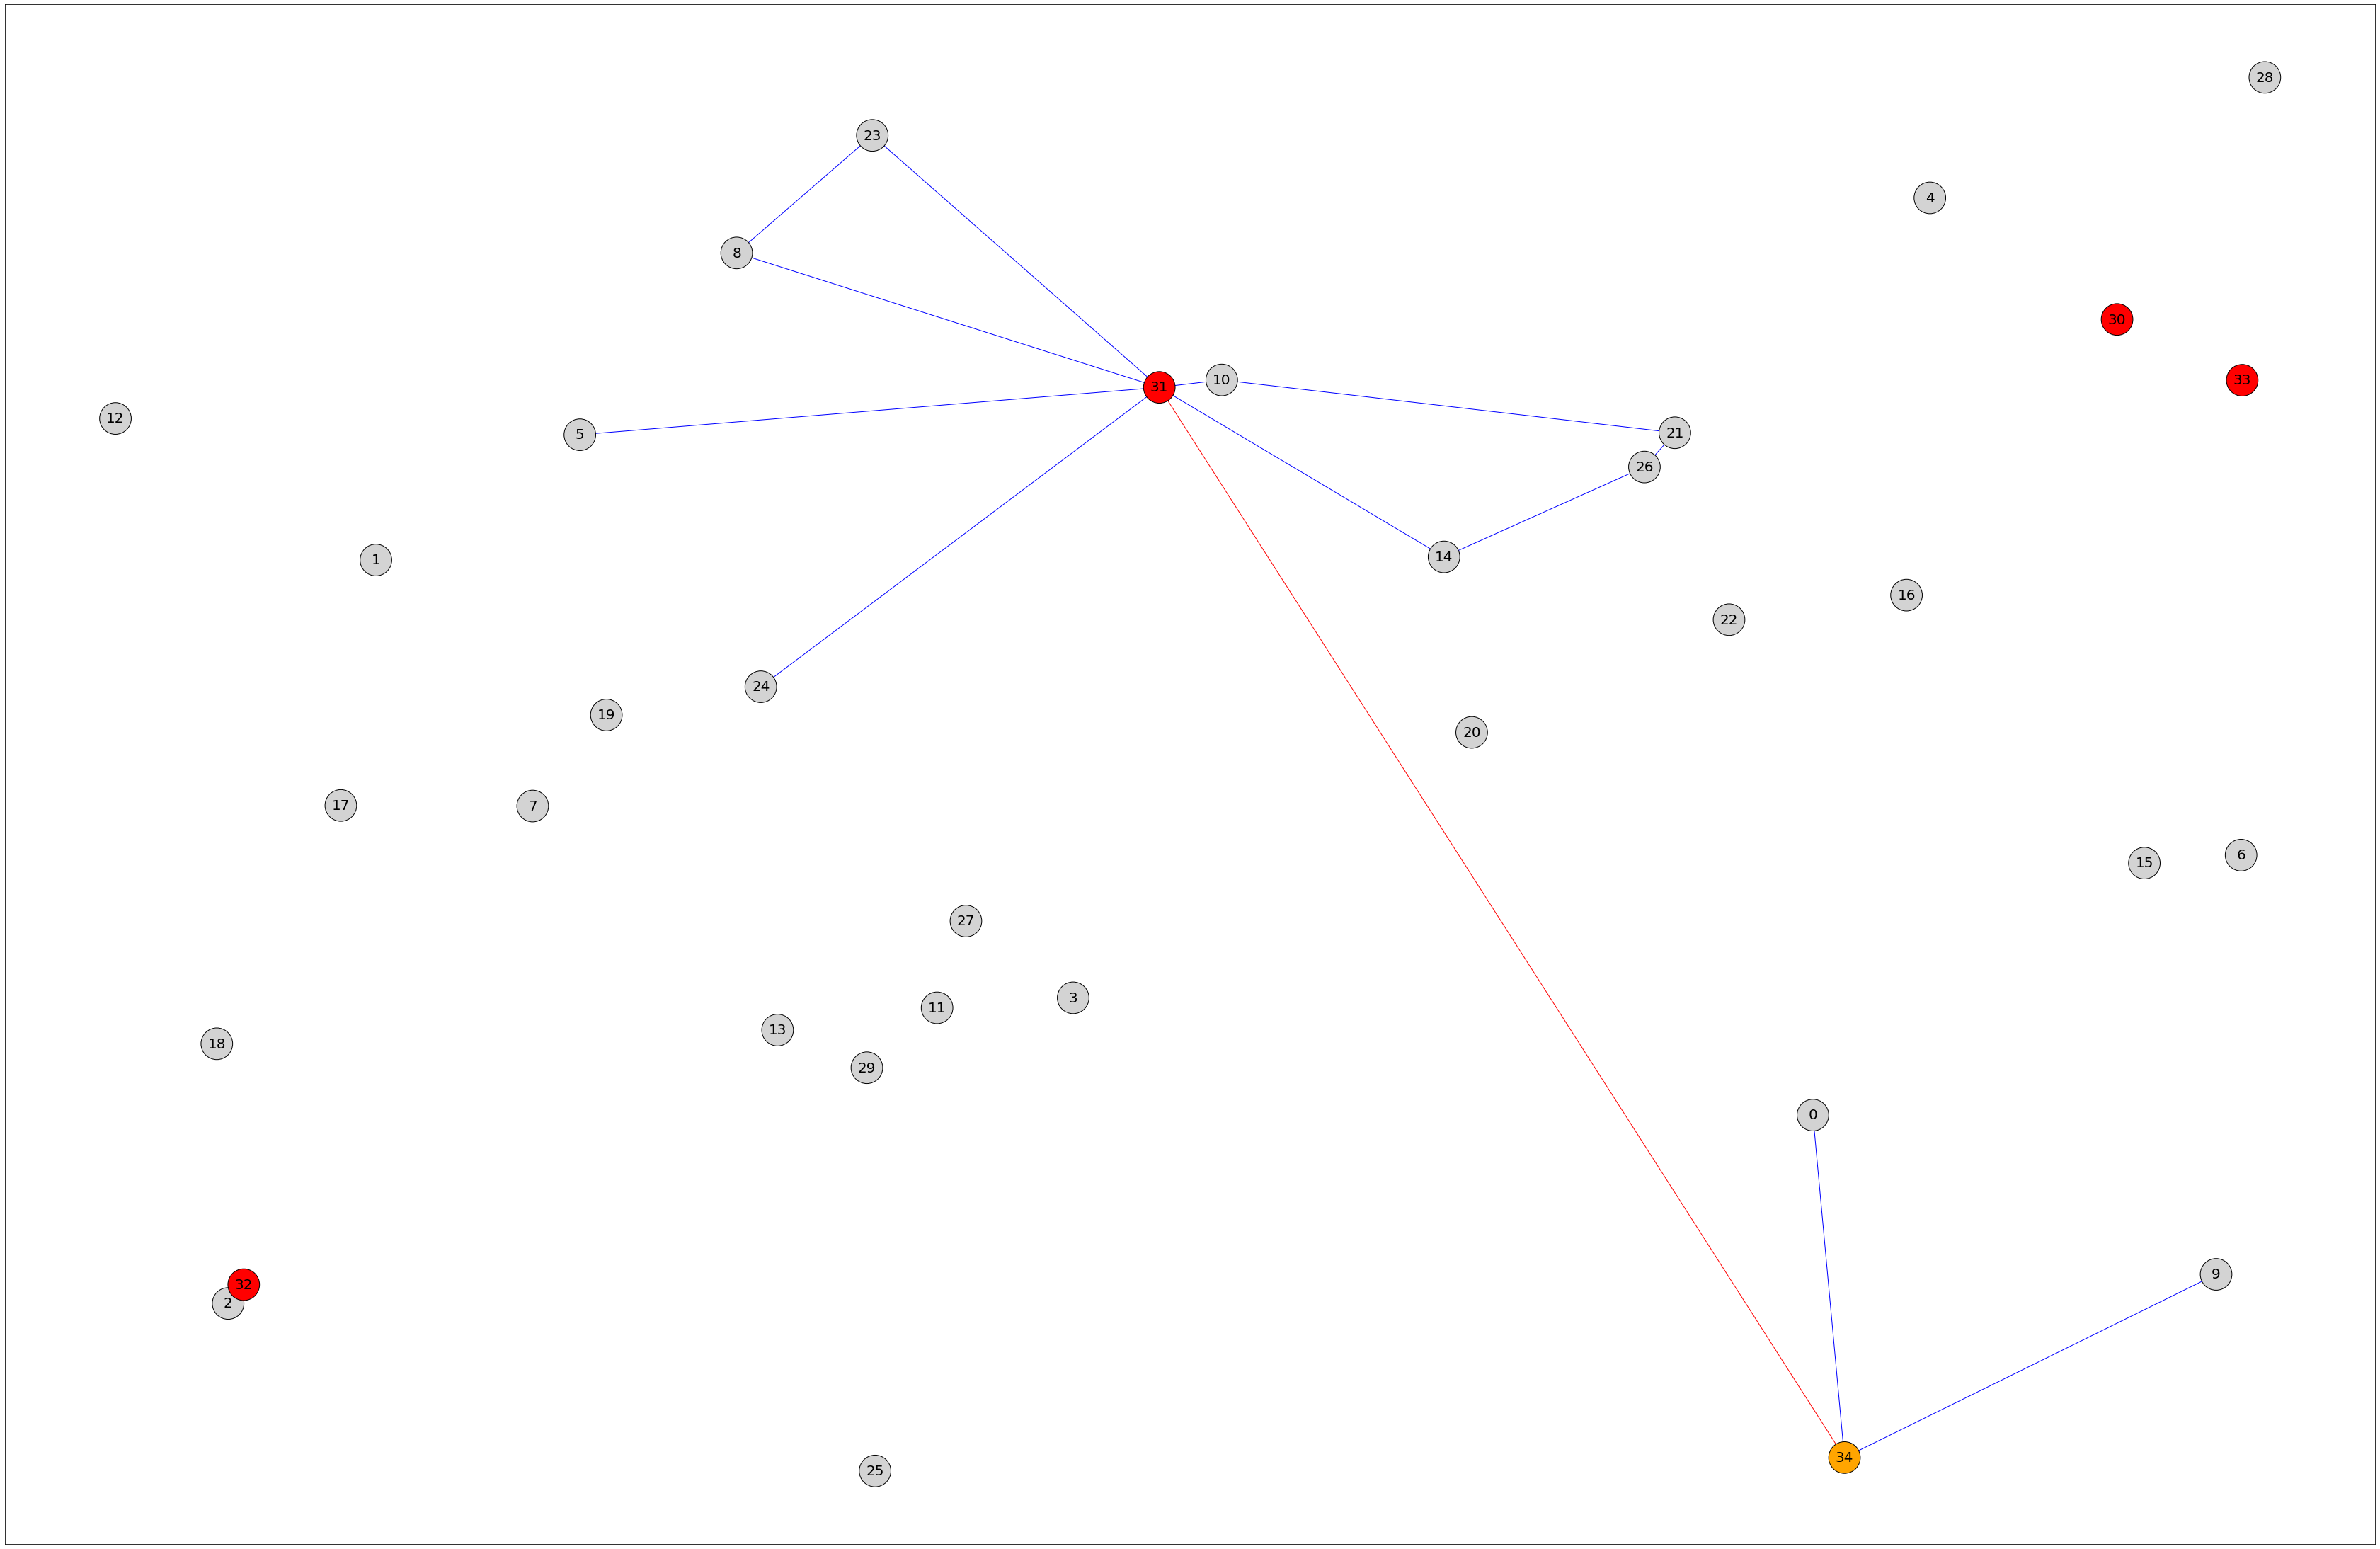

In [21]:
(m,n) = distance_rc_matrix.shape
graph = nx.Graph()
graph.add_nodes_from(list(nodes))
fig, ax = plt.subplots(figsize=(60, 40))
node_colors = ['lightgray' if i < m else'red'
               for i in graph.nodes]
node_colors[m+n-2] = 'orange'
nx.draw_networkx_nodes(graph, pos=pos, ax=ax, node_color=node_colors,
                       edgecolors='black', node_size=2000)
nx.draw_networkx_labels(graph, pos=pos, ax=ax, labels=dict(zip(nodes, nodes)),
                        font_size=20)
graph.add_edges_from(list(edges))
edge_colors = ['blue' if i<m or j<m else 'red'
               for (i, j) in graph.edges]
nx.draw_networkx_edges(graph, pos=pos, ax=ax, node_size=2000, edge_color=edge_colors, arrowsize=25)
plt.show()